# Imports

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import os
import torchvision.transforms.functional as F
import torchvision.transforms
import torch.optim.lr_scheduler as lr_scheduler
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import torch.optim as optim
from skimage.transform import radon, iradon
from skimage.io import imread
from PIL import Image
from scipy.ndimage import rotate


# Directiry Setup

In [2]:
drive.mount('/content/drive')
os.chdir('/content/drive/Othercomputers/My MacBook Pro/Mega/Master Studies/Studying/Introduction to Deep Learning (18786)/Mini project/Miniproject')

Mounted at /content/drive


# Load Data

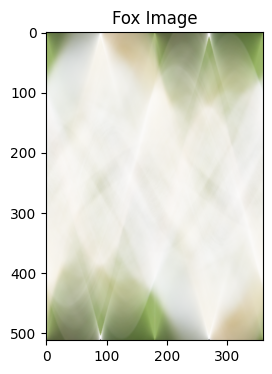

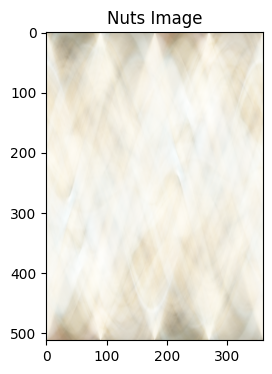

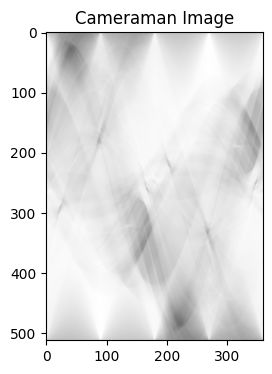

(512, 360, 3)


In [3]:
image_fox = plt.imread('data/nlradon/fox.tiff')/255.0
data_fox = np.load('data/nlradon/fox.npy') 
plt.figure(figsize=(4, 4)) # initiate figure
plt.imshow(image_fox)
plt.title('Fox Image')
plt.show()
image_fox = plt.imread('data/image/fox.jpg')/255.0


image_nuts = plt.imread('data/nlradon/nuts.tiff')/255.0
data_nuts = np.load('data/nlradon/nuts.npy')
# data_shepp = np.stack((data_shepp[:,:,0], data_shepp[:,:,0], data_shepp[:,:,0]), axis=-1)
plt.figure(figsize=(4, 4)) # initiate figure
plt.imshow(image_nuts)
plt.title('Nuts Image')
plt.show()

image_man = plt.imread('data/nlradon/cameraman.tiff')/255.0
data_cameraman = np.load('data/nlradon/cameraman.npy')
# data_cameraman = np.stack((data_cameraman[:,:,0], data_cameraman[:,:,0], data_cameraman[:,:,0]), axis=-1)
plt.figure(figsize=(4, 4)) # initiate figure
plt.imshow(image_man)
plt.title('Cameraman Image')
plt.show()
print(data_nuts.shape)

## Notes on images:


*   **Cameraman:** the image is three channels, but the numpy data is single channel
*   **Nuts:** Both are three channels
*   **Fox:** Both are three channels





# Cameraman

## Prepare input and output data

In [33]:
## Input Features:
p = np.linspace(0, 1, 512)
q = np.linspace(0, 1, 512)
X = np.meshgrid(p, q)
X = np.stack(X, axis=-1).reshape(-1, 2).astype(np.float32)
# X = torch.from_numpy(X) # to tensor

## Forier features:
b = np.random.normal(0, 100, (512,2))
cos_b = np.cos(2 * np.pi * (X@b.T))
sin_b = np.sin(2 * np.pi * (X@b.T))
X = np.zeros((X.shape[0], b.shape[0]*2))
X[:,0::2] = cos_b
X[:,1::2] = sin_b
X = torch.from_numpy(X) # to tensor
X = X.to(torch.float32)

## Output labels:
print(data_cameraman.shape)
# y = data_cameraman.reshape(-1, data_cameraman.shape[-1]).astype(np.float32)
y = data_cameraman
y = torch.from_numpy(y) # to tensor

## Output shape:
out_dim = 1

(512, 360, 1)


## Define network

In [34]:
# Define MLP architecture
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 1024)
        self.fc4 = nn.Linear(1024, 512)
        self.fc5 = nn.Linear(512, 256)
        self.fc6 = nn.Linear(256, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.sigmoid(self.fc6(x))

        return x

## Define non-linear radon transform

In [35]:
class nlradon_loss(nn.Module):
  def __init__(self):
        super(nlradon_loss, self).__init__()

  def forward(self, output, target):
    theta = torch.arange(0, 360, dtype=float, requires_grad=True)
    output = output.reshape(512,512,1)

    for ii, angle in enumerate(theta):
      image_man_rotate = F.rotate(output.permute(2,0,1), float(angle))
      image_man_rotate = image_man_rotate.permute(1,2,0)
      
      image_man_rotate_integral = torch.exp(-0.01*torch.cumsum(image_man_rotate, dim=1))
      image_man_rotate_mul = image_man_rotate_integral*image_man_rotate

      if ii == 0: image_radon_angle = (torch.sum(image_man_rotate_mul, dim=1)).unsqueeze(1)
      else: image_radon_angle = torch.cat((image_radon_angle, torch.sum(image_man_rotate_mul, dim=1).unsqueeze(1)), dim=1)

    criterion = nn.MSELoss()
    # print('Loss: ', image_radon_angle.shape, target.shape)
    loss = criterion(image_radon_angle.float(), target.float())

    return image_radon_angle, loss


## Train and Test

In [36]:
## Use CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Define network:
net = MLP(input_dim=X.shape[-1], output_dim=out_dim).to(device)

# define optimizer and loss:
criterion = nlradon_loss()
optimizer = optim.Adam(net.parameters(),  lr=0.001)

## Train the model
num_epochs = 1000
num_samples = X.shape[0]
psnr_list = []
ssim_list = []
loss_man_list = []

for epoch in range(num_epochs):

  # get data to device
  X = X.to(device)
  y = y.to(device)

  # Forward pass
  y_pred = net(X)

  # Loss
  _, loss = criterion(y_pred, y)

  # Backward pass and optimization
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Calculate PSNR and SSIM and append to list
  y_pred = y_pred.detach().cpu().numpy()
  image_pred = y_pred.reshape((512, 512, 1))
  # image_pred = np.flip(rotate(image_pred, -90, reshape=True, order=1, mode='constant', cval=0, prefilter=True), axis=1)

  loss_man_list.append(loss.item())

  # Print loss after every epoch
  print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, PSNR: {0:.4f}, SSIM: {0:.4f}')

Epoch [1/1000], Loss: 71.2841, PSNR: 0.0000, SSIM: 0.0000
Epoch [2/1000], Loss: 63.3601, PSNR: 0.0000, SSIM: 0.0000
Epoch [3/1000], Loss: 64.6803, PSNR: 0.0000, SSIM: 0.0000
Epoch [4/1000], Loss: 64.2796, PSNR: 0.0000, SSIM: 0.0000
Epoch [5/1000], Loss: 63.3840, PSNR: 0.0000, SSIM: 0.0000
Epoch [6/1000], Loss: 63.7605, PSNR: 0.0000, SSIM: 0.0000
Epoch [7/1000], Loss: 63.2777, PSNR: 0.0000, SSIM: 0.0000
Epoch [8/1000], Loss: 63.0217, PSNR: 0.0000, SSIM: 0.0000
Epoch [9/1000], Loss: 63.3821, PSNR: 0.0000, SSIM: 0.0000
Epoch [10/1000], Loss: 62.8576, PSNR: 0.0000, SSIM: 0.0000
Epoch [11/1000], Loss: 62.9563, PSNR: 0.0000, SSIM: 0.0000
Epoch [12/1000], Loss: 63.0329, PSNR: 0.0000, SSIM: 0.0000
Epoch [13/1000], Loss: 62.8228, PSNR: 0.0000, SSIM: 0.0000
Epoch [14/1000], Loss: 62.6160, PSNR: 0.0000, SSIM: 0.0000
Epoch [15/1000], Loss: 62.7359, PSNR: 0.0000, SSIM: 0.0000
Epoch [16/1000], Loss: 62.5974, PSNR: 0.0000, SSIM: 0.0000
Epoch [17/1000], Loss: 62.3877, PSNR: 0.0000, SSIM: 0.0000
Epoch 

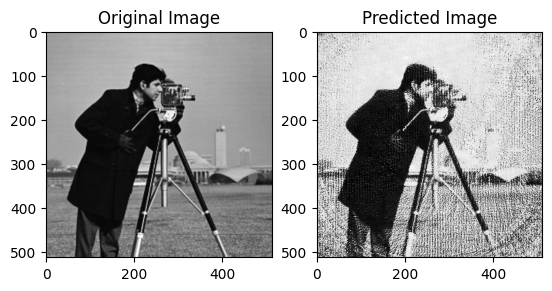

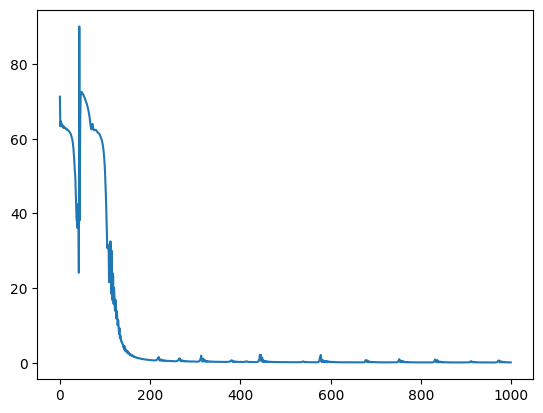

In [37]:
# plt.imshow(image_pred/image_pred.max(), cmap=plt.get_cmap('gray'))
# plt.title('Predicted Image')
# plt.show()
# plt.plot(loss_man_list)
# plt.title('Loss vs. epoch')


fig, ax = plt.subplots(1, 2)
image_man = plt.imread('data/image/cameraman.jpg')/255.0
ax[0].imshow(image_man/image_man.max(), cmap=plt.get_cmap('gray'))
ax[0].set_title('Original Image')

image_pred_test = image_pred
image_pred_test = np.flip(rotate(image_pred_test, 90, reshape=True, order=1, mode='constant', cval=0, prefilter=True), axis=0 )
# image_pred_test = np.flip(image_pred_test, axis=0)
ax[1].imshow(image_pred_test/image_pred_test.max(), cmap=plt.get_cmap('gray'))
ax[1].set_title('Predicted Image')
plt.show()

plt.show()
image_pred.shape

plt.plot(loss_man_list)

# Nuts

## Prepare input and output data

In [50]:
## Input Features:
p = np.linspace(0, 1, 512)
q = np.linspace(0, 1, 512)
X = np.meshgrid(p, q)
X = np.stack(X, axis=-1).reshape(-1, 2).astype(np.float32)
# X = torch.from_numpy(X) # to tensor

## Forier features:
b = np.random.normal(0, 100, (512,2))
cos_b = np.cos(2 * np.pi * (X@b.T))
sin_b = np.sin(2 * np.pi * (X@b.T))
X = np.zeros((X.shape[0], b.shape[0]*2))
X[:,0::2] = cos_b
X[:,1::2] = sin_b
X = torch.from_numpy(X) # to tensor
X = X.to(torch.float32)

## Output labels:
print(data_nuts.shape)
# y = data_cameraman.reshape(-1, data_cameraman.shape[-1]).astype(np.float32)
y = data_nuts
y = torch.from_numpy(y) # to tensor

## Output shape:
out_dim = 3

(512, 360, 3)


## Define network

In [51]:
# Define MLP architecture
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 1024)
        self.fc4 = nn.Linear(1024, 512)
        self.fc5 = nn.Linear(512, 256)
        self.fc6 = nn.Linear(256, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.sigmoid(self.fc6(x))

        return x

## Define non-linear radon transform

In [54]:
class nlradon_loss(nn.Module):
  def __init__(self):
        super(nlradon_loss, self).__init__()

  def forward(self, output, target):
    theta = torch.arange(0, 360, dtype=float, requires_grad=True)
    output = output.reshape(512,512,3)

    for ii, angle in enumerate(theta):
      image_man_rotate = F.rotate(output.permute(2,0,1), float(angle))
      image_man_rotate = image_man_rotate.permute(1,2,0)
      
      image_man_rotate_integral = torch.exp(-0.01*torch.cumsum(image_man_rotate, dim=1))
      image_man_rotate_mul = image_man_rotate_integral*image_man_rotate

      if ii == 0: image_radon_angle = (torch.sum(image_man_rotate_mul, dim=1)).unsqueeze(1)
      else: image_radon_angle = torch.cat((image_radon_angle, torch.sum(image_man_rotate_mul, dim=1).unsqueeze(1)), dim=1)

    criterion = nn.MSELoss()
    # print('Loss: ', image_radon_angle.shape, target.shape)
    loss = criterion(image_radon_angle.float(), target.float())

    return image_radon_angle, loss


## Train and Test

In [55]:
## Use CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Define network:
net = MLP(input_dim=X.shape[-1], output_dim=out_dim).to(device)

# define optimizer and loss:
criterion = nlradon_loss()
optimizer = optim.Adam(net.parameters(),  lr=0.001)

## Train the model
num_epochs = 1000
num_samples = X.shape[0]
psnr_list = []
ssim_list = []
loss_man_list = []

for epoch in range(num_epochs):

  # get data to device
  X = X.to(device)
  y = y.to(device)

  # Forward pass
  y_pred = net(X)

  # Loss
  _, loss = criterion(y_pred, y)

  # Backward pass and optimization
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Calculate PSNR and SSIM and append to list
  y_pred = y_pred.detach().cpu().numpy()
  image_pred = y_pred.reshape((512, 512, 3))

  loss_man_list.append(loss.item())

  # Print loss after every epoch
  print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, PSNR: {0:.4f}, SSIM: {0:.4f}')

Epoch [1/1000], Loss: 21.9157, PSNR: 0.0000, SSIM: 0.0000
Epoch [2/1000], Loss: 14.5143, PSNR: 0.0000, SSIM: 0.0000
Epoch [3/1000], Loss: 79.6979, PSNR: 0.0000, SSIM: 0.0000
Epoch [4/1000], Loss: 13.0596, PSNR: 0.0000, SSIM: 0.0000
Epoch [5/1000], Loss: 16.3120, PSNR: 0.0000, SSIM: 0.0000
Epoch [6/1000], Loss: 18.2607, PSNR: 0.0000, SSIM: 0.0000
Epoch [7/1000], Loss: 19.0582, PSNR: 0.0000, SSIM: 0.0000
Epoch [8/1000], Loss: 19.3727, PSNR: 0.0000, SSIM: 0.0000
Epoch [9/1000], Loss: 19.4401, PSNR: 0.0000, SSIM: 0.0000
Epoch [10/1000], Loss: 19.3384, PSNR: 0.0000, SSIM: 0.0000
Epoch [11/1000], Loss: 19.1129, PSNR: 0.0000, SSIM: 0.0000
Epoch [12/1000], Loss: 18.7664, PSNR: 0.0000, SSIM: 0.0000
Epoch [13/1000], Loss: 18.2839, PSNR: 0.0000, SSIM: 0.0000
Epoch [14/1000], Loss: 17.6624, PSNR: 0.0000, SSIM: 0.0000
Epoch [15/1000], Loss: 16.8713, PSNR: 0.0000, SSIM: 0.0000
Epoch [16/1000], Loss: 15.9195, PSNR: 0.0000, SSIM: 0.0000
Epoch [17/1000], Loss: 14.8914, PSNR: 0.0000, SSIM: 0.0000
Epoch 

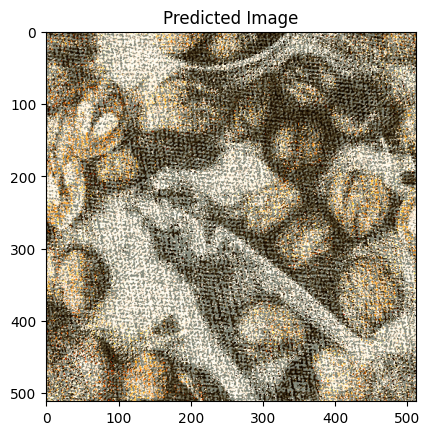

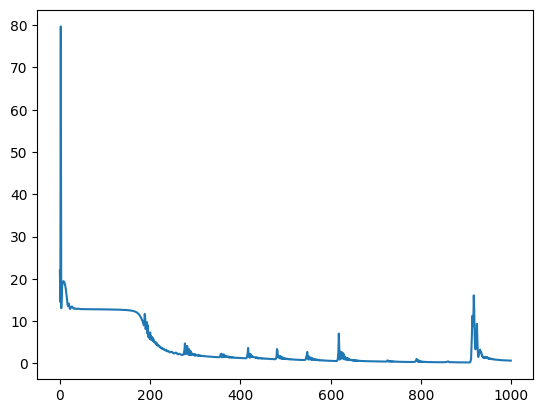

In [58]:
plt.imshow(image_pred/image_pred.max(), cmap=plt.get_cmap('gray'))
plt.title('Predicted Image')
plt.show()
plt.plot(loss_man_list)

# Fox

## Prepare input and output data

In [4]:
## Input Features:
p = np.linspace(0, 1, 512)
q = np.linspace(0, 1, 512)
X = np.meshgrid(p, q)
X = np.stack(X, axis=-1).reshape(-1, 2).astype(np.float32)
# X = torch.from_numpy(X) # to tensor

## Forier features:
b = np.random.normal(0, 100, (512,2))
cos_b = np.cos(2 * np.pi * (X@b.T))
sin_b = np.sin(2 * np.pi * (X@b.T))
X = np.zeros((X.shape[0], b.shape[0]*2))
X[:,0::2] = cos_b
X[:,1::2] = sin_b
X = torch.from_numpy(X) # to tensor
X = X.to(torch.float32)

## Output labels:
print(data_fox.shape)
# y = data_cameraman.reshape(-1, data_cameraman.shape[-1]).astype(np.float32)
y = data_fox
y = torch.from_numpy(y) # to tensor

## Output shape:
out_dim = 3

(512, 360, 3)


## Define network

In [5]:
# Define MLP architecture
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 1024)
        self.fc4 = nn.Linear(1024, 512)
        self.fc5 = nn.Linear(512, 256)
        self.fc6 = nn.Linear(256, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.sigmoid(self.fc6(x))

        return x

## Define non-linear radon transform

In [6]:
class nlradon_loss(nn.Module):
  def __init__(self):
        super(nlradon_loss, self).__init__()

  def forward(self, output, target):
    theta = torch.arange(0, 360, dtype=float, requires_grad=True)
    output = output.reshape(512,512,3)

    for ii, angle in enumerate(theta):
      image_man_rotate = F.rotate(output.permute(2,0,1), float(angle))
      image_man_rotate = image_man_rotate.permute(1,2,0)
      
      image_man_rotate_integral = torch.exp(-0.01*torch.cumsum(image_man_rotate, dim=1))
      image_man_rotate_mul = image_man_rotate_integral*image_man_rotate

      if ii == 0: image_radon_angle = (torch.sum(image_man_rotate_mul, dim=1)).unsqueeze(1)
      else: image_radon_angle = torch.cat((image_radon_angle, torch.sum(image_man_rotate_mul, dim=1).unsqueeze(1)), dim=1)

    criterion = nn.MSELoss()
    # print('Loss: ', image_radon_angle.shape, target.shape)
    loss = criterion(image_radon_angle.float(), target.float())

    return image_radon_angle, loss


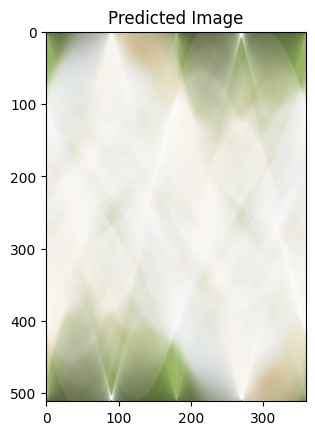

In [7]:
plt.imshow(y/y.max())
plt.title('Predicted Image')
plt.show()

## Train and Test

In [8]:
# ## Use CUDA if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ## Define network:
# net = MLP(input_dim=X.shape[-1], output_dim=out_dim).to(device)

# # define optimizer and loss:
# criterion = nlradon_loss()
# optimizer = optim.Adam(net.parameters(),  lr=0.001)

# ## Train the model
# num_epochs = 700
# num_samples = X.shape[0]
# psnr_list = []
# ssim_list = []
# loss_fox_list = []

for epoch in range(num_epochs):

  # get data to device
  X = X.to(device)
  y = y.to(device)

  # Forward pass
  y_pred = net(X)

  # Loss
  _, loss = criterion(y_pred, y)

  # Backward pass and optimization
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Calculate PSNR and SSIM and append to list
  y_pred = y_pred.detach().cpu().numpy()
  image_pred = y_pred.reshape((512, 512, 3))
  image_pred = np.flip(rotate(image_pred, -90, reshape=True, order=1, mode='constant', cval=0, prefilter=True), axis=1)

  loss_fox_list.append(loss.item())
  # print(image_pred.shape, image_fox.shape)
  # print('here5: ', image_pred.dtype.type)
  psnr = peak_signal_noise_ratio(image_fox, image_pred)
  ssim = structural_similarity(image_fox, image_pred, multichannel=True)
  psnr_list.append(psnr)
  ssim_list.append(ssim)
  loss_fox_list.append(loss.item())

  # Print loss after every epoch
  print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, SSIM: {ssim:.4f}, PSNR: {psnr:.4f}')

<ipython-input-8-1991dbd3be00>:43: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(image_fox, image_pred)
<ipython-input-8-1991dbd3be00>:44: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = structural_similarity(image_fox, image_pred, multichannel=True)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


Epoch [1/700], Loss: 162.3543, SSIM: 0.4844, PSNR: 10.9174
Epoch [2/700], Loss: 134.3737, SSIM: 0.4933, PSNR: 11.1001
Epoch [3/700], Loss: 249.5430, SSIM: 0.5159, PSNR: 10.1861
Epoch [4/700], Loss: 122.4983, SSIM: 0.4989, PSNR: 11.0874
Epoch [5/700], Loss: 141.1497, SSIM: 0.4918, PSNR: 11.0674
Epoch [6/700], Loss: 149.2678, SSIM: 0.4892, PSNR: 11.0208
Epoch [7/700], Loss: 152.4641, SSIM: 0.4881, PSNR: 10.9984
Epoch [8/700], Loss: 153.7114, SSIM: 0.4877, PSNR: 10.9890
Epoch [9/700], Loss: 154.0661, SSIM: 0.4876, PSNR: 10.9863
Epoch [10/700], Loss: 153.9202, SSIM: 0.4877, PSNR: 10.9872
Epoch [11/700], Loss: 153.4393, SSIM: 0.4878, PSNR: 10.9906
Epoch [12/700], Loss: 152.7008, SSIM: 0.4881, PSNR: 10.9957
Epoch [13/700], Loss: 151.7025, SSIM: 0.4885, PSNR: 11.0024
Epoch [14/700], Loss: 150.3169, SSIM: 0.4891, PSNR: 11.0113
Epoch [15/700], Loss: 148.4226, SSIM: 0.4898, PSNR: 11.0226
Epoch [16/700], Loss: 145.8409, SSIM: 0.4909, PSNR: 11.0363
Epoch [17/700], Loss: 142.3259, SSIM: 0.4923, PSN

KeyboardInterrupt: ignored

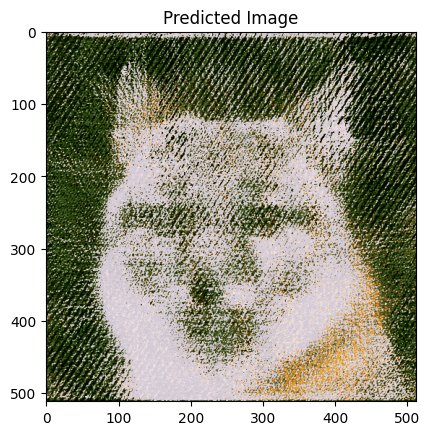

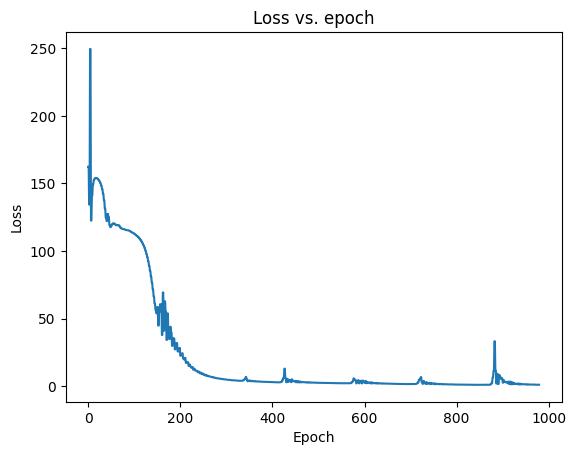

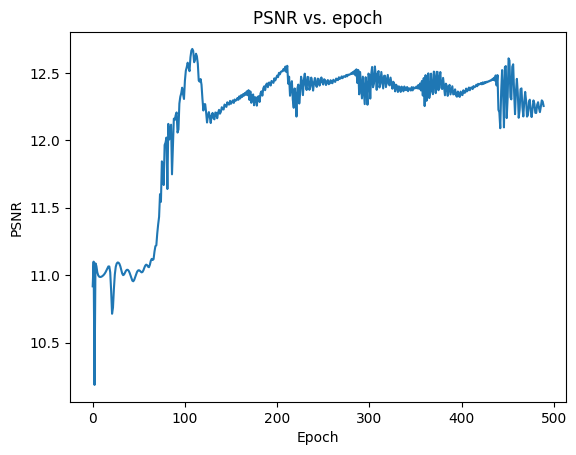

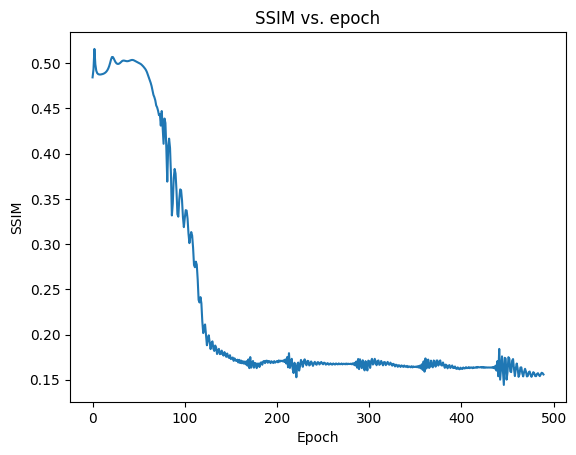

In [9]:
plt.imshow(image_pred/image_pred.max())
plt.title('Predicted Image')
plt.show()

plt.plot(loss_fox_list)
plt.title('Loss vs. epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(psnr_list)
plt.title('PSNR vs. epoch')
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.show()

plt.plot(ssim_list)
plt.title('SSIM vs. epoch')
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.show() 